In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d 'balraj98/deepglobe-road-extraction-dataset'

100% 3.78G/3.79G [00:37<00:00, 107MB/s]
100% 3.79G/3.79G [00:37<00:00, 108MB/s]


In [6]:
!unzip deepglobe-road-extraction-dataset.zip -d road-detection

Streaming output truncated to the last 5000 lines.
  inflating: road-detection/train/723199_sat.jpg  
  inflating: road-detection/train/723226_mask.png  
  inflating: road-detection/train/723226_sat.jpg  
  inflating: road-detection/train/723436_mask.png  
  inflating: road-detection/train/723436_sat.jpg  
  inflating: road-detection/train/723483_mask.png  
  inflating: road-detection/train/723483_sat.jpg  
  inflating: road-detection/train/723622_mask.png  
  inflating: road-detection/train/723622_sat.jpg  
  inflating: road-detection/train/723722_mask.png  
  inflating: road-detection/train/723722_sat.jpg  
  inflating: road-detection/train/723970_mask.png  
  inflating: road-detection/train/723970_sat.jpg  
  inflating: road-detection/train/723990_mask.png  
  inflating: road-detection/train/723990_sat.jpg  
  inflating: road-detection/train/724095_mask.png  
  inflating: road-detection/train/724095_sat.jpg  
  inflating: road-detection/train/724431_mask.png  
  inflating: road-dete

In [13]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import os
import shutil


input_dir = 'road-detection/train'


output_sat_dir = os.path.join(input_dir, 'sat')
output_mask_dir = os.path.join(input_dir, 'mask')

os.makedirs(output_sat_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)


for filename in os.listdir(input_dir):
    if filename.endswith('sat.jpg'):
        shutil.move(os.path.join(input_dir, filename), os.path.join(output_sat_dir, filename))
    elif filename.endswith('mask.png'):
        shutil.move(os.path.join(input_dir, filename), os.path.join(output_mask_dir, filename))



In [8]:
!pip install split-folders

In [9]:
import splitfolders
splitfolders.ratio('road-detection/train', output="datasplit", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 12452 files [00:21, 580.69 files/s] 


In [36]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from torchvision.transforms import v2
import random

class SatDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace("sat.jpg", "mask.png"))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        #mask[mask == 255.0] = 1.0

        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)

        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
            greyscaler = v2.Grayscale(num_output_channels=1)
            mask = greyscaler(mask)
        return image, mask

In [37]:
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_set = SatDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,

    )

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_set = SatDataset(
        image_dir = val_dir,
        mask_dir= val_maskdir,
        transform= val_transform
    )

    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [51]:
from torchvision.transforms import v2
import torch

#import albumentations as A
#from albumentations.pytorch import ToTensorV2




train_transform = v2.Compose(
    [
        v2.Resize((256,256)),
        #v2.RandomResizedCrop(size=(256, 256), antialias=True),
        #v2.RandomHorizontalFlip(p=0.5),
        v2.ToTensor(),
        v2.Normalize(mean=[0.0, 0.0, 0.0],std=[1.0, 1.0, 1.0])
    ]
)
'''

train_transform = v2.Compose(
    [

        v2.RandomResizedCrop(size=(256, 256), antialias=True),
        #v2.RandomHorizontalFlip(p=0.5),
        v2.ToTensor(),
        v2.Normalize(mean=[0.0, 0.0, 0.0],std=[1.0, 1.0, 1.0])
    ]
)
'''

val_transforms = v2.Compose(
    [
        v2.Resize((256,256)),
        v2.ToTensor(),
        v2.Normalize(mean=[0.0, 0.0, 0.0],std=[1.0, 1.0, 1.0])

    ]
)

'''
train_transform = A.Compose(
        [
            A.Resize(height=256, width=256),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
        [
            A.Resize(height=256, width=256),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

'''

TRAIN_IMG_DIR = "datasplit/train/sat/"
TRAIN_MASK_DIR = "datasplit/train/mask/"

VAL_IMG_DIR = "datasplit/test/sat/"
VAL_MASK_DIR = "datasplit/test/mask/"

BATCH_SIZE= 16
PIN_MEMORY = True
NUM_WORKERS = 2

train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

In [56]:
sample_train, sample_mask = next(iter(train_loader))

In [58]:
import matplotlib.pyplot as plt

def get_image_tensor(loader, idx):
  img = loader[idx]
  print(img.shape)
  img = img.permute(2,1,0)
  return img


torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


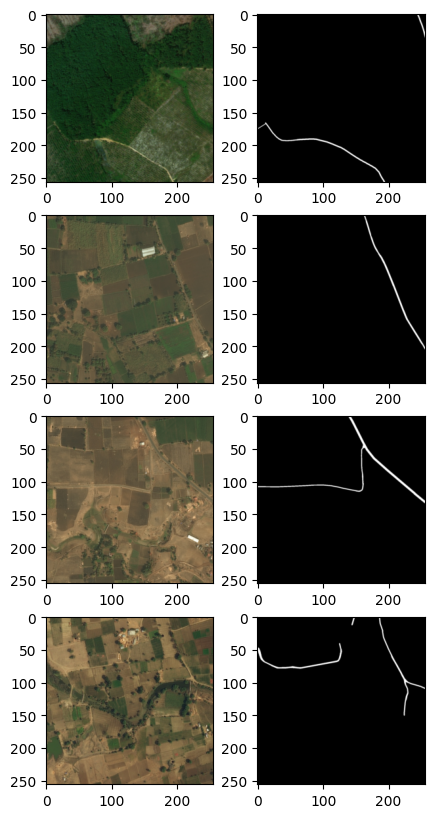

In [59]:
import matplotlib.pyplot as plt

rows = 4
current_img=0

f, ax = plt.subplots(rows,2, figsize=(5,10))


for row in range(rows):
    img = get_image_tensor(sample_train, current_img)
    mask = get_image_tensor(sample_mask, current_img)
    ax[row, 0].imshow(img)
    ax[row, 1].imshow(mask.squeeze(), cmap='gray')
    current_img+=1



In [ ]:
import torch.nn as nn


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, X):
        return self.conv(X)

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs =nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(in_channels=feature*2, out_channels= feature, kernel_size=2, stride=2)) # multiply feature by 2 to account for skip connection
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(in_channels=features[-1], out_channels=features[-1]*2)
        self.final=  nn.Conv2d(features[0], out_channels=out_channels, kernel_size=1)

    def forward(self, X):
        skip_connections = []
        for i, down in enumerate(self.downs):
            X = down(X)
            skip_connections.append(X)
            X = self.pool(X)


        X = self.bottleneck(X)
        skip_connections = list(reversed(skip_connections))


        for i in range(0, len(self.ups), 2):
            X = self.ups[i](X)
            skip_conn = skip_connections[i//2]
            #if X.shape != skip_conn.shape:
                #X = TF.resize(X, size=skip_conn.shape[2:])

            concat_skip = torch.cat((skip_conn,X), dim=1)
            X = self.ups[i+1](concat_skip)

        finalX = self.final(X)
        return self.final(X)

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device='cuda')
        targets = targets.float().unsqueeze(1).to(device='cuda')


        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


In [ ]:
import torchvision

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def save_predictions_as_imgs(
    loader, model, folder="saved_images", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/{idx}.png")

    model.train()

In [ ]:
import torch.optim as optim
from tqdm import tqdm


LEARNING_RATE = 1e-4
NUM_EPOCHS= 5
LOAD_CHECKPOINT= True

model = UNET(in_channels=3, out_channels=1).to('cuda')
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

if LOAD_CHECKPOINT:
        print("loading checkpoints")
        load_checkpoint(torch.load("gdrive/MyDrive/best_checkpoint.pth.tar"), model)
        print("loaed checkpoint from gdrive")

check_accuracy(val_loader, model, device='cuda')
scaler = torch.cuda.amp.GradScaler()
for epoch in range(NUM_EPOCHS):
        print(f"Current epoch {epoch}")
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }

        save_checkpoint(checkpoint, filename=f'checkpoints/epoch_{epoch}_checkpoint.pth.tar')
        print(f"Checkpoint saved for epoch {epoch}")

        # check accuracy
        check_accuracy(val_loader, model, device='cuda')

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images", device='cuda'
        )



loading checkpoints
=> Loading checkpoint
loaed checkpoint from gdrive
Got 39724303/40894464 with acc 97.14
Dice score: 0.6334189176559448
Current epoch 0


100%|██████████| 312/312 [02:42<00:00,  1.93it/s, loss=0.0704]


=> Saving checkpoint
Checkpoint saved for epoch 0
Got 39742151/40894464 with acc 97.18
Dice score: 0.583346426486969
Current epoch 1


100%|██████████| 312/312 [02:44<00:00,  1.90it/s, loss=0.0598]


=> Saving checkpoint
Checkpoint saved for epoch 1
Got 39780137/40894464 with acc 97.28
Dice score: 0.6473280191421509
Current epoch 2


100%|██████████| 312/312 [02:36<00:00,  1.99it/s, loss=0.0558]


=> Saving checkpoint
Checkpoint saved for epoch 2
Got 39807912/40894464 with acc 97.34
Dice score: 0.6505206227302551
Current epoch 3


100%|██████████| 312/312 [02:38<00:00,  1.96it/s, loss=0.0523]


=> Saving checkpoint
Checkpoint saved for epoch 3
Got 39767128/40894464 with acc 97.24
Dice score: 0.6565942764282227
Current epoch 4


100%|██████████| 312/312 [02:37<00:00,  1.98it/s, loss=0.0385]


=> Saving checkpoint
Checkpoint saved for epoch 4
Got 39795322/40894464 with acc 97.31
Dice score: 0.6418423652648926


In [ ]:
os.mkdir('saved_images')

In [ ]:
from PIL import Image
image = Image.open('vit1 (1).jpg')

In [ ]:
from torchvision.transforms import v2

trans = v2.PILToTensor()
img_tensor = trans(image)

In [ ]:
img_tensor.shape

torch.Size([3, 821, 1753])

torch.Size([3, 255, 255])


IndexError: index 3 is out of bounds for dimension 0 with size 3

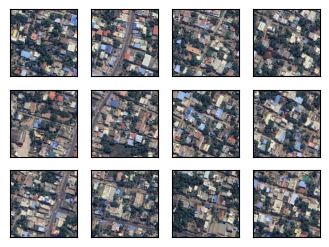

In [ ]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

%matplotlib inline

transt = transforms.ToTensor()
transp = transforms.ToPILImage()
img_t = transt(Image.open('vit1 (1).jpg'))

#torch.Tensor.unfold(dimension, size, step)
#slices the images into 8*8 size patches
patches = img_t.data.unfold(0, 3, 3).unfold(1, 8, 8).unfold(2, 8, 8)


print(patches[0][0][0].shape)

def visualize(patches):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(4, 4))
    for i in range(4):
        for j in range(4):
            inp = transt(patches[0][i][j])
            inp = np.array(inp)

            ax = fig.add_subplot(4, 4, ((i*4)+j)+1, xticks=[], yticks=[])
            plt.imshow(inp)

visualize(patches)

In [ ]:
bruh = img_t.data.unfold(0, 3, 3)

In [ ]:
bruh.unfold(1, 8, 8).shape

torch.Size([1, 102, 1753, 3, 8])

In [ ]:
img_t.shape

torch.Size([3, 821, 1753])

In [ ]:
import torch

# Your original tensor
original_tensor = torch.randn(3, 821, 1753)

# Specify block size
block_size = (256, 256)

# Use unfold to create a view of the tensor as blocks
unfolded_tensor = original_tensor.unfold(1, block_size[0], block_size[0]).unfold(2, block_size[1], block_size[1])

# Get the size of the unfolded tensor
unfolded_size = unfolded_tensor.size()

# Reshape the unfolded tensor to get the final result
result_tensor = unfolded_tensor.reshape(unfolded_size[0], unfolded_size[1], unfolded_size[2], block_size[0], block_size[1])

# Check the size of the result tensor
print(result_tensor.size())



torch.Size([3, 3, 6, 256, 256])


In [ ]:
import torch

# Assuming result_tensor is your unfolded tensor
result_tensor = torch.randn(3, 3, 6, 256, 256)

# Get the dimensions of the unfolded tensor
num_channels, num_blocks_dim1, num_blocks_dim2, block_size_dim1, block_size_dim2 = result_tensor.size()

# Iterate over each dimension to extract each block
for channel_idx in range(num_channels):
    for block_idx_dim1 in range(num_blocks_dim1):
        for block_idx_dim2 in range(num_blocks_dim2):
            # Extract a single block
            block = result_tensor[channel_idx, block_idx_dim1, block_idx_dim2, :, :]

            # Now 'block' is a tensor of size (256, 256), representing one block of the original tensor
            # You can perform operations on 'block' or store it as needed
            print(f"Channel {channel_idx}, Block {block_idx_dim1}, {block_idx_dim2}:\n", block.shape)


Channel 0, Block 0, 0:
 torch.Size([256, 256])
Channel 0, Block 0, 1:
 torch.Size([256, 256])
Channel 0, Block 0, 2:
 torch.Size([256, 256])
Channel 0, Block 0, 3:
 torch.Size([256, 256])
Channel 0, Block 0, 4:
 torch.Size([256, 256])
Channel 0, Block 0, 5:
 torch.Size([256, 256])
Channel 0, Block 1, 0:
 torch.Size([256, 256])
Channel 0, Block 1, 1:
 torch.Size([256, 256])
Channel 0, Block 1, 2:
 torch.Size([256, 256])
Channel 0, Block 1, 3:
 torch.Size([256, 256])
Channel 0, Block 1, 4:
 torch.Size([256, 256])
Channel 0, Block 1, 5:
 torch.Size([256, 256])
Channel 0, Block 2, 0:
 torch.Size([256, 256])
Channel 0, Block 2, 1:
 torch.Size([256, 256])
Channel 0, Block 2, 2:
 torch.Size([256, 256])
Channel 0, Block 2, 3:
 torch.Size([256, 256])
Channel 0, Block 2, 4:
 torch.Size([256, 256])
Channel 0, Block 2, 5:
 torch.Size([256, 256])
Channel 1, Block 0, 0:
 torch.Size([256, 256])
Channel 1, Block 0, 1:
 torch.Size([256, 256])
Channel 1, Block 0, 2:
 torch.Size([256, 256])
Channel 1, Bl

In [ ]:
num_blocks = tuple((original_tensor.size(i) - block_size[i] + 1) // block_size[i] for i in range(1, 3))